# Proyecto Colaborativo

> El proyecto consiste en el desarrollo de un proceso ETL básico con el objetivo de realizar un análisis estadístico de datos.

## ETL - Extract, Transform, Load

Un proceso (o pipeline) ETL es una secuencia de operaciones de **descarga, transformación y carga de datos**. La estructura de un ETL, por lo tanto, se desarrolla de manera secuencial.
- Primero realizamos una **extracción automatizada** de información desde alguna fuente de datos, típicamente una **base de datos o API**.
- Una vez los datos están todos extraídos, **se procesan** para facilitar las tareas para las cuales se van a utilizar estos datos. Por ejemplo, podemos transformar nuestros datos de una estructura de dos tablas relacionadas entre sí, en una estructura de una única tabla combinada. Durante esta etapa también se realiza la **limpieza de datos**, que consiste en ajustar la información a un formato fácilmente procesable (ej. convertir strings de fechas a objetos `datetime`, convertir valores como `--` o `?` en `np.nan` para facilitar análisis de valores perdidos, etc.).
- Cuando los datos ya están transformados y listos para el caso de uso, se almacenan conservando este nuevo formato, con el objetivo de no repetir todo el proceso de extracción y transformación de nuevo cada vez que se quieran utilizar. El almacenamiento típicamente se realiza en una **base de datos**, o estructuras de almacenamiento más permisivas como **data lakes** y **sistemas de ficheros**. Esto último dependerá de la naturaleza de la información y de las restricciones técnicas y económicas del proyecto.

Existen dos formas comunes de diseñar e implementar un proceso ETL:
- La primera, y la más fácil, es una en la que extraemos todos los datos, luego procesamos todo, y luego almacenamos todo.
- La segunda, un poco más difícil, pero a la vez robusta a grandes volúmenes de datos, consiste en procesar y almacenar la información sobre la marcha, mientras se está extrayendo.

## Fases del proyecto

En este proyeco se espera la implementación completa de una pipeline ETL destinada a facilitar un análisis de datos de cara a un cliente final. Estas son las fases del proyecto:

- **ETL**: Realizamos el proceso descrito anteriormente, mediante la técnica de implementación que prefieran. La fuente de datos debe ser una o varias API(s) pública(s) a elección del equipo y validada según el criterio del docente. Los datos se almacenarán en el sistema de ficheros del ordenador.
- **Análisis de Datos**: Con los datos transformados y almacenados, se tiene que realizar un estudio y análisis de la información que contienen. El estudio tiene que tener un foco claro y unas preguntas objetivo que se desean responder. El estudio tiene que comprender la exploración de la información y la presentación de visualizaciones y medidas estadísticas que ayuden a responder a las preguntas objetivo.
- **Entrega**: La entrega del proyecto se realizará a través del correo electrónico. Un representante del equipo enviará un email adjuntando el enlace al repositorio público de GitHub (u otro servicio cloud de Git, Como GitLab, BitBucket o Codeberg). En el repositorio tienen que estar presentes todos los notebooks utilizados para el trabajo, bien estructurados e idealmente enumerados en orden de ejecución para todo aquel que quiera probar el código. Es importante el uso correcto de `.gitignore` para evitar saturar el repositorio con ficheros y carpetas que no aporten valor al trabajo, así como para escribir en un fichero ignorado información sensible como credenciales de las APIs.

In [1]:
#EXTRACCIÓN DE DATOS

In [19]:
import requests
import json
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
with open("api.txt", "r") as f:
    apikey = f.readline().strip()
    secret = f.readline().strip()
FM=requests.get("http://www.last.fm/api/auth/", params={"api_key": apikey})

In [22]:

#Funcion que utilizaremos para extraer de nuestro api

def lastfm_get(urlhead):
    
    headers = {
        'user-agent': 'Lilmaik'
    }
    url = 'https://ws.audioscrobbler.com/2.0/'

    
    urlhead['api_key'] = apikey
    urlhead['format'] = 'json'

    response = requests.get(url, headers=headers, params=urlhead)
    return response

     

In [23]:
#funcion para transformar ceros a NaNs

def to_nan_if_zero(value):
    return np.nan if value == 0 else value

In [24]:
#función para ordenar por la columna que nos interesa analizar en el DataFrame
def column_sort (df, column):
   if column not in df.columns:
       raise ValueError(f"La columna '{column}' no existe en el DF")
   return df.sort_values(column, ascending=False)


In [36]:
#Data Tracks
toptracks = lastfm_get({
    'method': 'chart.gettoptracks',
    'country' : '',
    'limit' : '299'
})

data_tracks = toptracks.json()
top_tracks = data_tracks["tracks"]["track"]

tracks_limpios = []

for t in top_tracks:
    tracks_limpios.append({
        "song name": t["name"],
        "artist": t["artist"]["name"],
        "song duration": to_nan_if_zero(int(t["duration"])),
        "song playcount": to_nan_if_zero(int(t["playcount"])),
        "song listeners": to_nan_if_zero(int(t["listeners"]))
    })
    


dftracks=pd.DataFrame(tracks_limpios)
df1 = dftracks.sort_values(["song playcount","song listeners"] , ascending=False).reset_index().drop(['index'], axis=1)
df1
#celda para obtener nuestros top tracks y limpiador de datos

,song name,artist,song duration,song playcount,song listeners
0,Pink + White,Frank Ocean,290.0,55380504,2296816
1,"Good Luck, Babe!",Chappell Roan,218.0,54433740,1934104
2,Creep,Radiohead,235.0,54273229,3858938
3,505,Arctic Monkeys,305.0,52842275,2823378
4,See You Again (feat. Kali Uchis),"Tyler, The Creator",180.0,52581284,2400875
...,...,...,...,...,...
294,Predictable Girl,FKA twigs,147.0,424214,91852
295,HARD,FKA twigs,214.0,391746,93239
296,Love Crimes,FKA twigs,160.0,330873,78972
297,Wild And Alone (feat. PinkPantheress),FKA twigs,NaN,274116,85713


In [38]:
#Artistas

topartists = lastfm_get({
    'method': 'chart.gettopartists',
    'country' : '',
    'limit' : '299'
})

data_artists = topartists.json()
top_artists = data_artists["artists"]["artist"]

artists_limpios = []

for a in top_artists:
    artists_limpios.append({
        "artist": a["name"],
        "artist playcount": to_nan_if_zero(int(a["playcount"])),
        "artist listeners": to_nan_if_zero(int(a["listeners"]))
    })
  
    
        

dfartists=pd.DataFrame(artists_limpios)
df2 = dfartists.sort_values(["artist playcount","artist listeners"], ascending=False).reset_index().drop(['index'], axis=1)
df2
#celda para extraer los top artists y limpiar los datos

,artist,artist playcount,artist listeners
0,Taylor Swift,3459781066,5701914
1,BTS,2575085885,2210300
2,Lana Del Rey,1463312286,5033281
3,Kanye West,1433125334,7714955
4,Radiohead,1285464096,7963266
...,...,...,...
294,fakemink,36954803,312336
295,Olivia Dean,35545933,947219
296,HUNTR/X,33130776,932084
297,EsDeeKid,23055199,388314


In [39]:
#Genero

toptags = lastfm_get({
    'method': 'chart.getTopTags',
    'country' : '',
    'limit' : '299'
})

data_tags = toptags.json()
top_genre = data_tags["tags"]["tag"]

genre_limpios = []

for g in top_genre:
    genre_limpios.append({
        "genre name": g["name"],
        "reach": to_nan_if_zero(int(g["reach"])),
        "genre taggings": to_nan_if_zero(int(g["taggings"]))
    })

dfgenre=pd.DataFrame(genre_limpios)
df3 = dfgenre.sort_values("reach", ascending=False).reset_index().drop(['index'], axis=1)
df3
#celda para extraer los top generos y limpiar los datos

,genre name,reach,genre taggings
0,rock,402532,4064633
1,alternative,266974,2129165
2,electronic,261788,2491484
3,indie,260148,2063516
4,pop,233467,2076710
...,...,...,...
294,2010s,1403,63667
295,heard on Pandora,1172,63160
296,spotify,1053,71922
297,somafm,773,74224


In [40]:
#funcion para extraer el año de las canciones

def year_toptracks(artist, track):
        year = lastfm_get({
            'method': 'track.getInfo',
            'artist': artist,
            'track': track
        })
        
        data_year = year.json()

        wiki = data_year.get("track", {}).get('wiki')
        if wiki is None:
            return np.nan
        
        published = wiki.get("published")    

        match = re.search(r"\b(19|20)\d{2}\b", published)
        if match:
            return int(match.group(0))
    
        return np.nan

year_list = dftracks.apply(
    lambda row: year_toptracks(row["artist"], row["song name"]),
    axis=1
).tolist()


#year_list

In [41]:
#funcion para extraer las etiquetas "tags" de las canciones

def tags_toptracks(artist, track):
        taggings = lastfm_get({
            'method': 'track.getInfo',
            'artist': artist,
            'track': track
        })
        
        data_tag = taggings.json()

        tags = data_tag.get("track", {}).get('toptags', {}).get('tag')
    
        if tags is None:
            return np.nan
        
        tag_name = [tag.get("name", "") for tag in tags]   
        if len(tag_name) == 0:
            return np.nan
        return tag_name
   

tag_ = dftracks.apply(
    lambda row: tags_toptracks(row["artist"], row["song name"]),
    axis=1
).tolist()
        


tag_list = []
for sublista in tag_:
    if isinstance(sublista, list) and len(sublista) > 0:      
        tag_list.append(sublista[0])
    else:
        tag_list.append(np.nan)

#tag_list

In [42]:
#incluimos colunma "song year", "song tag" y casteamos las columnas a int

dftracks["song year"] = year_list
dftracks["song tag"] = tag_list

cols_numericas = ["song duration", "song playcount", "song listeners", "song year"]
dftracks[cols_numericas] = dftracks[cols_numericas].astype("Int64")

dfprincipal = dftracks
dfprincipal

,song name,artist,song duration,song playcount,song listeners,song year,song tag
0,The Fate of Ophelia,Taylor Swift,226,13938891,727272,2025,pop
1,Sienna,The Marías,224,13967190,941731,2025,dream pop
2,Dracula,Tame Impala,205,4123664,596124,2025,synth funk
3,Chains of Love,Charli xcx,170,709289,198915,2025,NaN
4,Tears,Sabrina Carpenter,160,9989729,819087,2025,sexy
...,...,...,...,...,...,...,...
294,Aerials,System of a Down,232,20655447,1988422,2023,alternative metal
295,Cheap Hotel,FKA twigs,212,910019,135971,<NA>,trip hop
296,PRIDE.,Kendrick Lamar,275,30917750,1716063,2017,Conscious Hip Hop
297,Kill Bill,SZA,154,42659622,2073818,2022,pop


In [43]:
#Reordenamos el top de canciones más escuchadas esta semana por número de reproducciones y de oyentes

df4=dfprincipal.sort_values(["song playcount","song listeners"] , ascending=False).reset_index().drop(['index'], axis=1)
df4                    

,song name,artist,song duration,song playcount,song listeners,song year,song tag
0,Pink + White,Frank Ocean,290,55380504,2296816,2025,NaN
1,"Good Luck, Babe!",Chappell Roan,218,54433740,1934104,2024,synthpop
2,Creep,Radiohead,235,54273229,3858938,2008,alternative
3,505,Arctic Monkeys,305,52842275,2823378,2017,indie rock
4,See You Again (feat. Kali Uchis),"Tyler, The Creator",180,52581284,2400875,2021,rnb
...,...,...,...,...,...,...,...
294,Predictable Girl,FKA twigs,147,424214,91852,<NA>,NaN
295,HARD,FKA twigs,214,391746,93239,<NA>,NaN
296,Love Crimes,FKA twigs,160,330873,78972,<NA>,NaN
297,Wild And Alone (feat. PinkPantheress),FKA twigs,<NA>,274116,85713,<NA>,NaN


In [44]:
#ANÁLISIS DE DATOS

Evolución de la popularidad por año:

Analizamos cómo cambia la popularidad de las canciones a lo largo de los años mediante las reproducciones. 
Del top de canciones más escuchadas esta semana, las agrupamos por año de lanzamiento y vemos las más escuchadas de cada año.

In [45]:
#En los distintos años de lanzamiento, canciones más escuchadas actualmente
top_songs_by_year = dfprincipal.loc[dfprincipal.groupby("song year")["song playcount"].idxmax()]
top_songs_by_year.reset_index()

,index,song name,artist,song duration,song playcount,song listeners,song year,song tag
0,7,Creep,Radiohead,235,54273229,3858938,2008,alternative
1,58,Mr. Brightside,The Killers,222,46760212,3472050,2009,rock
2,124,On Melancholy Hill,Gorillaz,233,25404458,2143922,2010,electronic
3,162,Judas,Lady Gaga,249,31222605,1806183,2011,pop
4,144,Thinkin Bout You,Frank Ocean,200,33527366,2076524,2012,rnb
5,16,Sweater Weather,The Neighbourhood,240,45742444,2770192,2013,indie
6,100,I Wanna Be Yours,Arctic Monkeys,55,38966980,2433914,2014,indie rock
7,183,Let It Happen,Tame Impala,466,23292093,1619757,2015,psychedelic
8,11,The Less I Know the Better,Tame Impala,217,43026775,2512408,2016,psychedelic
9,19,505,Arctic Monkeys,305,52842275,2823378,2017,indie rock


Análisis de duración de las canciones:

Ver si hay una tendencia en la duración de las canciones.

In [46]:
#Totales y estadística del tiempo de duración de las canciones
stats_duration = pd.DataFrame(dfprincipal["song duration"].describe())
stats_duration

,song duration
count,283.0
mean,219.54417
std,57.016614
min,55.0
25%,183.5
50%,218.0
75%,251.5
max,466.0


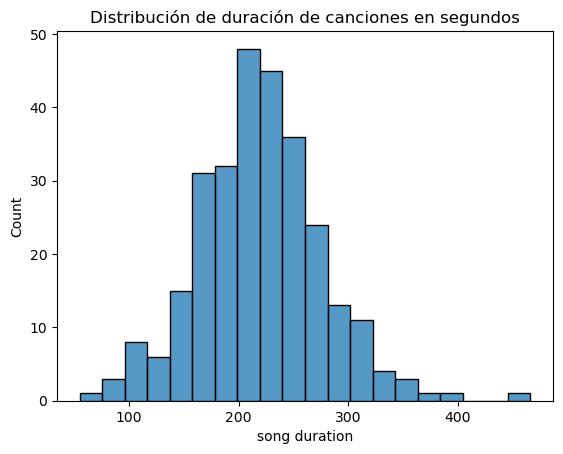

In [47]:
#Distribución de tiempo en segundos de canciones

sns.histplot(data=dfprincipal,  x="song duration")
plt.title("Distribución de duración de canciones en segundos")
plt.show() 

In [48]:
#Canción más corta y canción más larga
shortest= dfprincipal.loc[dfprincipal["song duration"].idxmin(), ["song name", "artist", "song duration"]]
longest= dfprincipal.loc[dfprincipal["song duration"].idxmax(), ["song name", "artist", "song duration"]]

df_min_max = pd.DataFrame([shortest, longest]) 
df_min_max.index = ["Shortest song", "Longest song"]

df_min_max

,song name,artist,song duration
Shortest song,I Wanna Be Yours,Arctic Monkeys,55
Longest song,Let It Happen,Tame Impala,466


                song playcount  song listeners
song playcount        1.000000        0.847392
song listeners        0.847392        1.000000


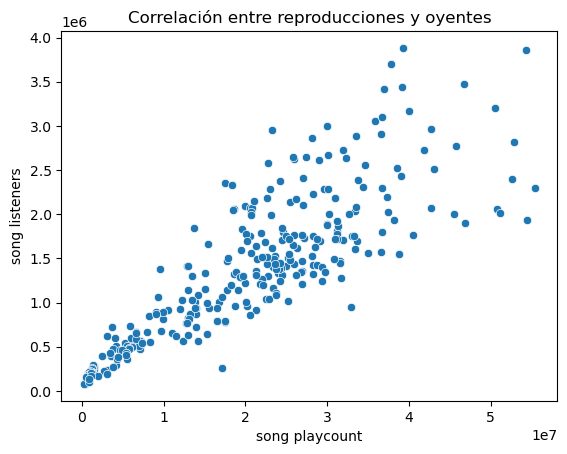

                  artist playcount  artist listeners
artist playcount          1.000000          0.428017
artist listeners          0.428017          1.000000


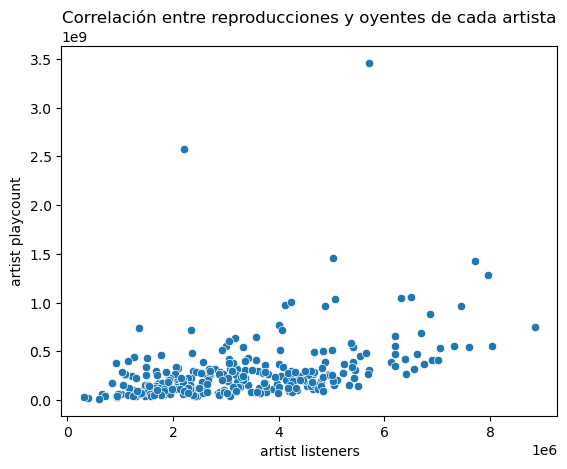

In [49]:
#Correlacion entre reproducciones y oyentes 
correlacion_playcount_listeners = dfprincipal[["song playcount", "song listeners"]].corr()
print(correlacion_playcount_listeners)
sns.scatterplot(data= dfprincipal, x = "song playcount", y = "song listeners")
plt.title("Correlación entre reproducciones y oyentes")
plt.show()

#Correlación entre reproducciones y oyentes de los artistas
correlacion_playcount_listeners = dfartists[["artist playcount", "artist listeners"]].corr()
correlacion_playcount_listeners
print(correlacion_playcount_listeners)
sns.scatterplot(data= dfartists, x = "artist listeners", y = "artist playcount")
plt.title("Correlación entre reproducciones y oyentes de cada artista")
plt.show()

La correlación entre oyentes y reproducciones de las canciones es estadísticamente significativa (0.848943) ya que la mayoría de oyentes abarca gran parte de la muestra de reproducciones. 
Sin embargo, la correlación de oyetes y reproducciones por cada artista es moderada-baja (0.419188).
Llama la atención que ambas correlaciones tengan índices tan diferentes.

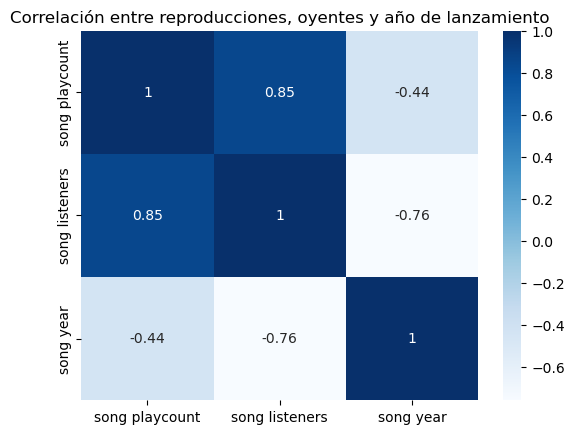

In [50]:
#Correlaciones de variables de reproducción y de oyentes con el año de lanzamiento de la canción
sns.heatmap(data = dfprincipal[["song playcount", "song listeners", "song year"]].corr(),
            annot = True,
            cmap = "Blues")
plt.title("Correlación entre reproducciones, oyentes y año de lanzamiento")
plt.show()

Hay una relación estadísticamente significativa entre las reproducciones y los oyentes (0.85), 
mientras que hay una relación negativa moderada entre los oyentes y el año en el que salieron las canciones (-0.78) 
y un poco menos fuerte (-0.48) entre las reproducciones y el año de lanzamiento de canciones.
Ambas pueden interpretarse en que el número de oyentes aumenta cuando es lanzada la canción y tiende a disminuir con el paso del tiempo.

In [51]:
#incluimos al dfartist las columnas :
    # num de apariciones del artista en dfprincipal
    # num reproducciones por persona (fidelidad)
    # num personas por reproducción (viralidad)

In [52]:
df_artist_count = dfprincipal["artist"].value_counts()
df_artist_count.columns = ["artist", "appearances dfprincipal"]

df_artist = pd.merge(
    left = dfartists,
    right = df_artist_count,
    left_on = "artist",
    right_on = "artist")

df_artist.columns = ["artist", "artist playcount", "artist listeners", "appearances dfprincipal"]

df_artist["repeats x listener"] = (dfartists ["artist playcount"] / dfartists ["artist listeners"])

df_artist["virality"] = ((dfartists ["artist listeners"] / dfartists ["artist playcount"])*100)

df_artist.head(10)

,artist,artist playcount,artist listeners,appearances dfprincipal,repeats x listener,virality
0,The Weeknd,1038749116,5071143,4,204.835304,0.488197
1,Radiohead,1285464096,7963266,9,161.424232,0.619486
2,"Tyler, The Creator",978143413,4112275,6,237.859436,0.420416
3,Taylor Swift,3459781066,5701914,9,606.775386,0.164806
4,Ariana Grande,1010524865,4222320,2,239.329294,0.417834
5,Kendrick Lamar,967028113,4871050,5,198.525598,0.503713
6,Kanye West,1433125334,7714955,3,185.759390,0.538331
7,Charli xcx,649477236,3564368,6,182.213856,0.548806
8,Lady Gaga,969590388,7456512,8,130.032700,0.769037
9,Sabrina Carpenter,557414946,3004003,15,185.557387,0.538917


In [53]:
#asignamos una variable con el nombre de cada columna 
#te devuelve el head(20) del df ordenado priorizando esa columna

In [54]:
artist_playcount = column_sort (df_artist, "artist playcount").head(20)
artist_listeners  = column_sort (df_artist, "artist listeners").head(20)
appearances_dfprincipal = column_sort (df_artist, "appearances dfprincipal").head(20)
repeats_listener = column_sort (df_artist, "repeats x listener").head(20)
virality = column_sort (df_artist, "virality").head(20)

**ARTISTAS CON MÁS PRESENCIA EN EL RANKING DE CANCIONES** 

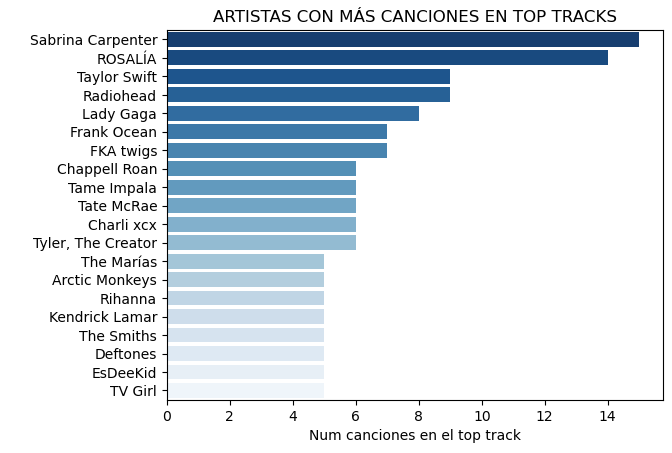

In [55]:
sns.barplot(
        x="appearances dfprincipal",
        y="artist",
        data=appearances_dfprincipal,
        palette="Blues_r",
        hue = "artist"
    )
plt.title("ARTISTAS CON MÁS CANCIONES EN TOP TRACKS")
plt.xlabel("Num canciones en el top track")
plt.ylabel(" ")
plt.show()

**ARTISTAS MÁS CONSOLIDADOS**

Analizamos los artistas que aparecen en la cabecera del mayor número de rankings.

Rankings = Num.reproducciones/Oyentes únicos/Canciones en el top mundial / Fidelidad / Viralidad

In [56]:
tops = [
    artist_playcount[["artist"]],
    artist_listeners[["artist"]],
    appearances_dfprincipal[["artist"]],
    repeats_listener[["artist"]],
    virality[["artist"]]
]


dftops = pd.concat(tops, ignore_index=True)

consolidaos = ((dftops.groupby("artist").size().reset_index(name="num_ranking").sort_values("num_ranking", ascending=False))).head(20)

#consolidaos

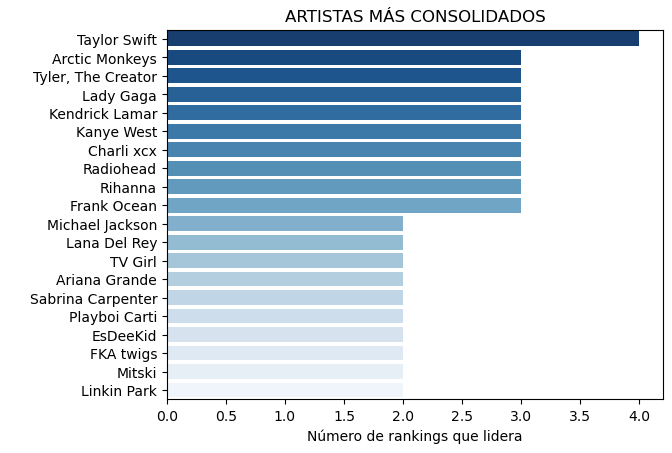

In [57]:
sns.barplot(
    data=consolidaos,
    x="num_ranking",
    y="artist",
    palette="Blues_r", 
    hue = "artist"
)

plt.title("ARTISTAS MÁS CONSOLIDADOS")
plt.xlabel("Número de rankings que lidera")
plt.ylabel(" ")
plt.show()

**ARTISTAS EMERGENTES**

Jugamos con el número de canciones que tiene en el top y el número de oyentes únicos.

In [58]:
df_emergents = df_artist.copy()
df_emergents["artist emergents"] = ((df_emergents["appearances dfprincipal"]/df_emergents["artist listeners"])*10e4)
df_emergents

artist_emergent = column_sort(df_emergents, "artist emergents").head(20)

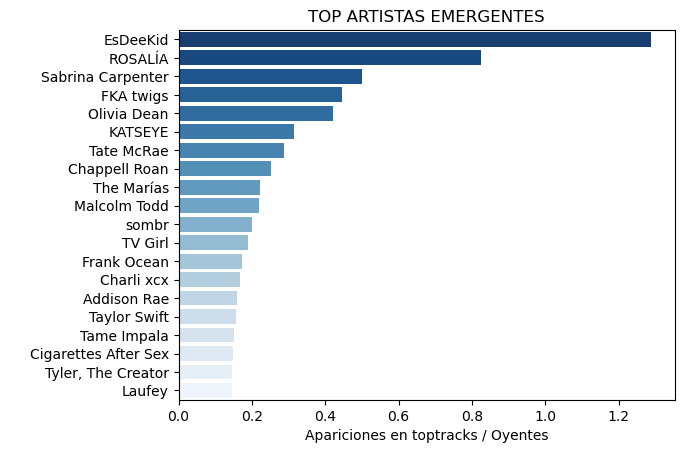

In [59]:
sns.barplot(
    data=artist_emergent,
    x="artist emergents",
    y="artist",
    palette="Blues_r", 
    hue = "artist"
)

plt.title("TOP ARTISTAS EMERGENTES")
plt.xlabel("Apariciones en toptracks / Oyentes")
plt.ylabel(" ")
plt.show()

**ANÁLISIS REPRODUCCIONES**

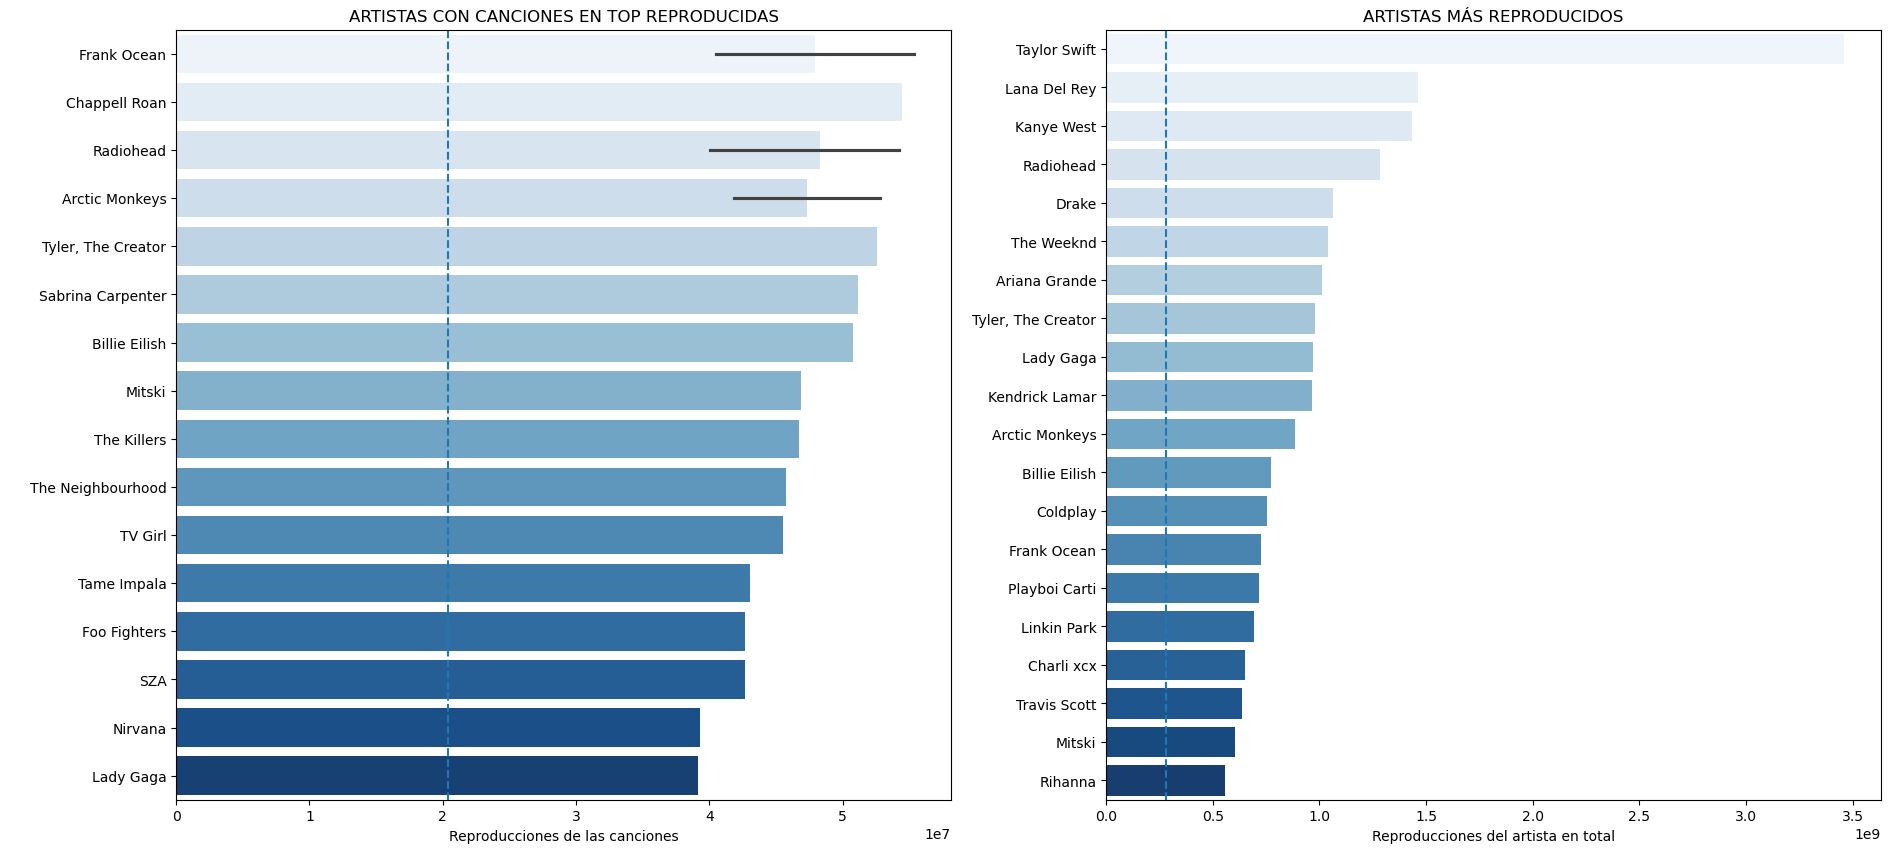

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,10))

song_playcount = column_sort(dfprincipal, "song playcount").head(20)
song_playcount_sorted = song_playcount.sort_values ("song playcount", ascending=False)

sns.barplot(
    data=song_playcount_sorted,
    x="song playcount",
    y="artist",
    palette="Blues",
    hue = "artist",
    ax=ax[0]
)

ax[0].axvline(dfprincipal["song playcount"].mean(), linestyle="--")
ax[0].set_title("ARTISTAS CON CANCIONES EN TOP REPRODUCIDAS")
ax[0].set_xlabel("Reproducciones de las canciones")
ax[0].set_ylabel(" ")

df_artist_sorted = df_artist.sort_values("artist playcount", ascending=False)

sns.barplot(
    data=df_artist_sorted.head(20),
    x="artist playcount",
    y="artist",
    palette="Blues",
    hue = "artist",
    ax=ax[1]
)
ax[1].axvline(dfartists["artist playcount"].mean(), linestyle="--")
ax[1].set_title("ARTISTAS MÁS REPRODUCIDOS")
ax[1].set_xlabel("Reproducciones del artista en total")
ax[1].set_ylabel(" ")

plt.show()

In [61]:
comunes_playcount = pd.merge(
    left = song_playcount, 
    right = artist_playcount, 
    left_on="artist", 
    right_on ="artist")

df_comunes_playcount = pd.DataFrame(comunes_playcount["artist"].unique(), columns=["artist"])
print(f" {len(df_comunes_playcount)} artistas en común")
print (df_comunes_playcount)

 7 artistas en común
               artist
0         Frank Ocean
1           Radiohead
2      Arctic Monkeys
3  Tyler, The Creator
4       Billie Eilish
5              Mitski
6           Lady Gaga


**ANÁLISIS OYENTES**

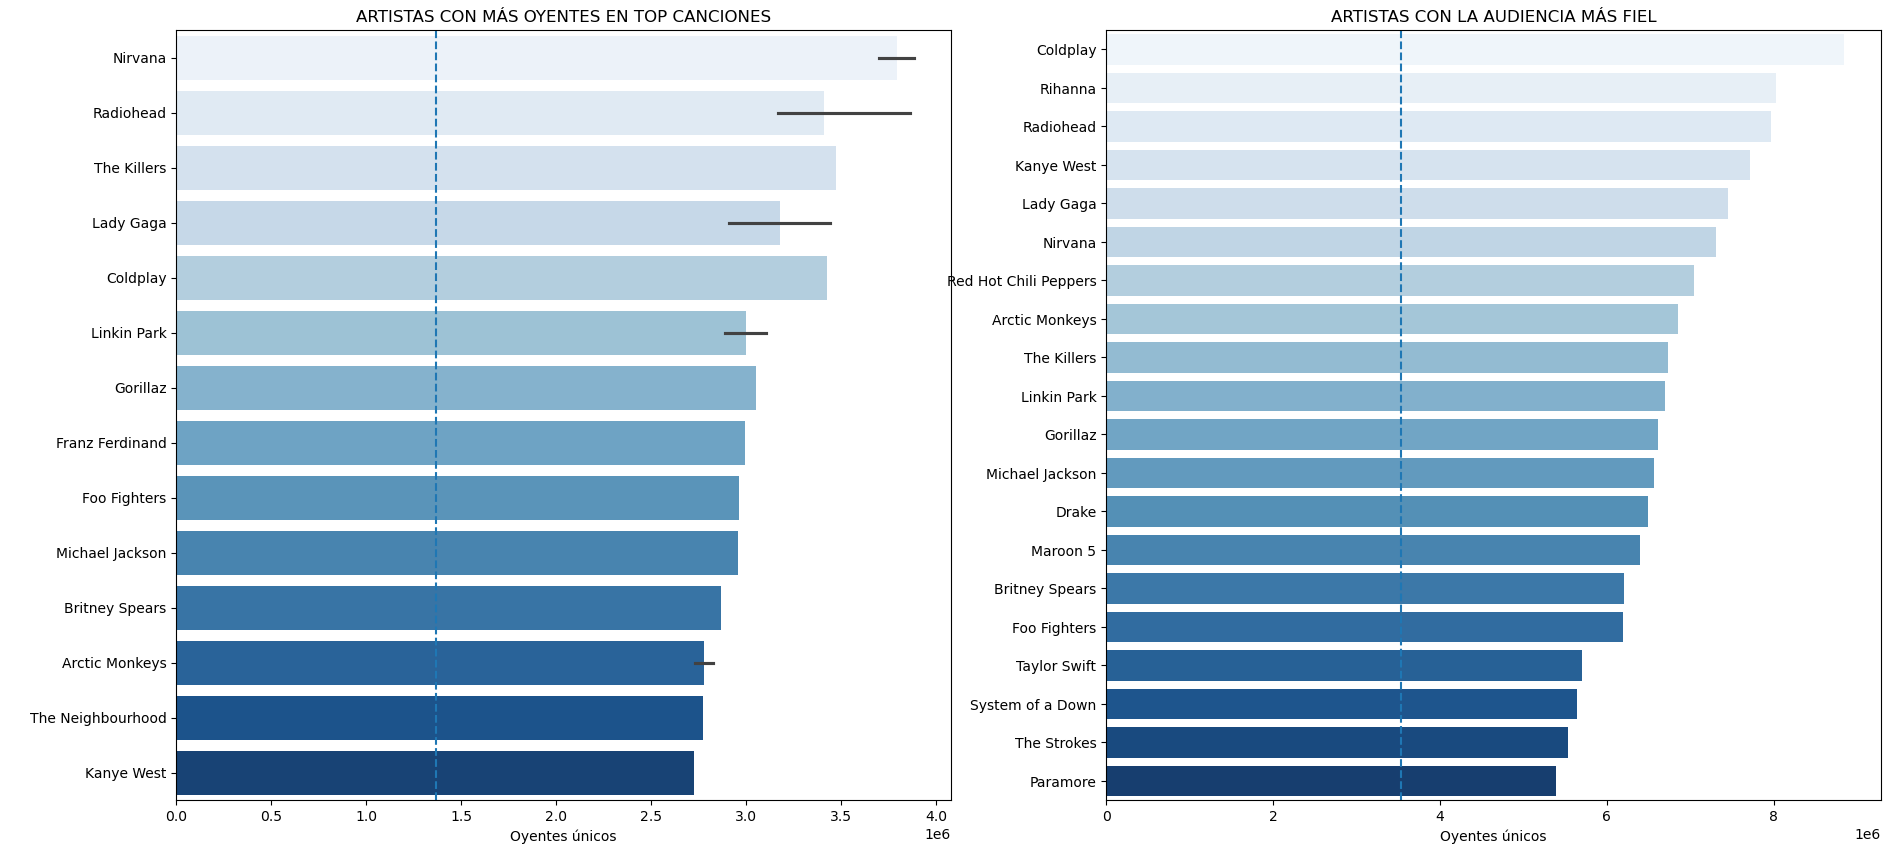

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,10))

song_listeners = column_sort(dfprincipal, "song listeners").head(20)
song_listeners_sorted = song_listeners.sort_values("song listeners", ascending = False)

sns.barplot(
    data=song_listeners_sorted,
    x="song listeners",
    y="artist",
    palette="Blues",
    hue = "artist",
    ax=ax[0]
)

ax[0].axvline(dfprincipal["song listeners"].mean(), linestyle="--")
ax[0].set_title("ARTISTAS CON MÁS OYENTES EN TOP CANCIONES")
ax[0].set_xlabel("Oyentes únicos")
ax[0].set_ylabel(" ")


artist_listeners_sorted = artist_listeners.sort_values("artist listeners", ascending = False)

sns.barplot(
    data=artist_listeners_sorted,
    x="artist listeners",
    y="artist",
    palette="Blues",
    hue = "artist",
    ax=ax[1]
)
ax[1].axvline(df_artist["artist listeners"].mean(), linestyle="--")
ax[1].set_title("ARTISTAS CON LA AUDIENCIA MÁS FIEL")
ax[1].set_xlabel("Oyentes únicos")
ax[1].set_ylabel(" ")

plt.show()

In [63]:
comunes_listeners = pd.merge(
    left = song_listeners, 
    right = artist_listeners, 
    left_on="artist", 
    right_on ="artist")

df_comunes_listeners = pd.DataFrame(comunes_listeners["artist"].unique(), columns=["artist"])
print(f" {len(df_comunes_listeners)} artistas en común")
print (df_comunes_listeners)

 12 artistas en común
             artist
0           Nirvana
1         Radiohead
2       The Killers
3         Lady Gaga
4          Coldplay
5       Linkin Park
6          Gorillaz
7      Foo Fighters
8   Michael Jackson
9    Britney Spears
10   Arctic Monkeys
11       Kanye West


**RELACIÓN REPRODUCCIONES/OYENTES CON ARTISTAS MÁS CONSOLIDADOS**

In [64]:
comunes = pd.merge(
    left = df_comunes_playcount, 
    right = df_comunes_listeners, 
    left_on="artist", 
    right_on ="artist")

df_comunes = pd.DataFrame(comunes["artist"].unique(), columns=["artist"])
print(f" {len(df_comunes)} artistas en común en las 4 gráficas")
print (df_comunes)

 3 artistas en común en las 4 gráficas
           artist
0       Radiohead
1  Arctic Monkeys
2       Lady Gaga


In [65]:
relacion_consolidaos = pd.merge(
    left = consolidaos, 
    right = df_comunes, 
    left_on="artist", 
    right_on ="artist",
    how = "inner"
)

print( f"{len(relacion_consolidaos)} artistas coinciden con los más consolidados")
print(relacion_consolidaos["artist"])

3 artistas coinciden con los más consolidados
0    Arctic Monkeys
1         Lady Gaga
2         Radiohead
Name: artist, dtype: object


**ANÁLISIS ESPAÑA**

In [74]:
spaintrack = lastfm_get({
    'method': 'geo.getTopTracks',
    'country' : 'Spain',
    'limit' : 299
})

In [75]:
spain_data_tracks = spaintrack.json()
spain_tracks = spain_data_tracks["tracks"]["track"]

spain_limpios = []

for t in spain_tracks:
    spain_limpios.append({
        "song name": t["name"],
        "artist": t["artist"]["name"],
        "song duration": to_nan_if_zero(int(t["duration"])),
        "song listeners": to_nan_if_zero(int(t["listeners"]))
    })

dfspaintracks=pd.DataFrame(spain_limpios)
dfspaintracks
#extraeremos las 299 canciones mas escuchadas en espana 

,song name,artist,song duration,song listeners
0,La Perla,ROSALÍA,NaN,10584
1,Reliquia,ROSALÍA,229.0,9299
2,"Sexo, Violencia y Llantas",ROSALÍA,140.0,8691
3,Berghain,ROSALÍA,178.0,8636
4,Dios Es Un Stalker,ROSALÍA,175.0,8401
...,...,...,...,...
294,SOPHIA,Rusowsky,184.0,858
295,Casual,Chappell Roan,232.0,856
296,S&M,Rihanna,243.0,856
297,Flashing Lights,Kanye West,238.0,855


In [76]:
songs_in_both = dfspaintracks[dfspaintracks["song name"].isin(dfprincipal["song name"])]

print(len(songs_in_both))
#aqui veremos cuantas canciones estan en las las dos tablas de el mundo y la de espana

147


In [77]:
song_name_in_both = set(dfspaintracks["song name"]).intersection(set(dfprincipal["song name"]))
song_name_link=pd.DataFrame(song_name_in_both)
pd.DataFrame(song_name_in_both)

#aqui veremos cuales son esas candiones

,0
0,Bad Romance
1,Back to the Old House - 2011 Remaster
2,Nobody’s Son
3,Timeless (Feat Playboi Carti)
4,Fade Into You
...,...
142,Ruin the Friendship
143,Where Have You Been
144,La Perla
145,TIT FOR TAT


In [78]:
spainartists = lastfm_get({
    'method': 'geo.getTopArtists',
    'country' : 'Spain',
    'limit' : 299
})

In [79]:
spain_artists = spainartists.json()
spain_top_artists = spain_artists["topartists"]["artist"]

spain_artists_limpios = []

for a in spain_top_artists:
    spain_artists_limpios.append({
        "artist" : a["name"],       
        "artist listeners": to_nan_if_zero(int(a["listeners"])),
    })


spain_artists_limpios
dfspainartists=pd.DataFrame(spain_artists_limpios)
dfspainartists
#haremos el print de los top 299 artistas en espana

,artist,artist listeners
0,ROSALÍA,17708
1,Bad Bunny,11059
2,Taylor Swift,9248
3,Charli xcx,7806
4,Ariana Grande,7780
...,...,...
294,guxo,1445
295,Juicy BAE,1439
296,Pixies,1432
297,Samuraï,1428


In [80]:
same_artists = dfspainartists[dfspainartists["artist"].isin(df2["artist"])]
print(len(same_artists))
#print de cuantos artistas estan en las tablas de espana y las del mundo

179


In [81]:
same_artists_names = set(dfspainartists["artist"]).intersection(set(df2["artist"]))
same_artists_names=pd.DataFrame(same_artists_names)
same_artists_names
#y quienes son esos artistas

,0
0,Frank Sinatra
1,Katy Perry
2,Clairo
3,Tame Impala
4,David Guetta
...,...
174,Gorillaz
175,The Cranberries
176,Conan Gray
177,Mitski


In [82]:
artists_world = len(df2["artist"].unique())

artists_world
#consiguiendo el porcentage de artistas del mundo estan tambien en la tabla de la de espana

299

In [83]:
spain_and_world = len(same_artists_names)
spain_and_world

179

In [84]:
percent = (spain_and_world / artists_world) * 100
percent

59.86622073578596

<Figure size 600x400 with 0 Axes>

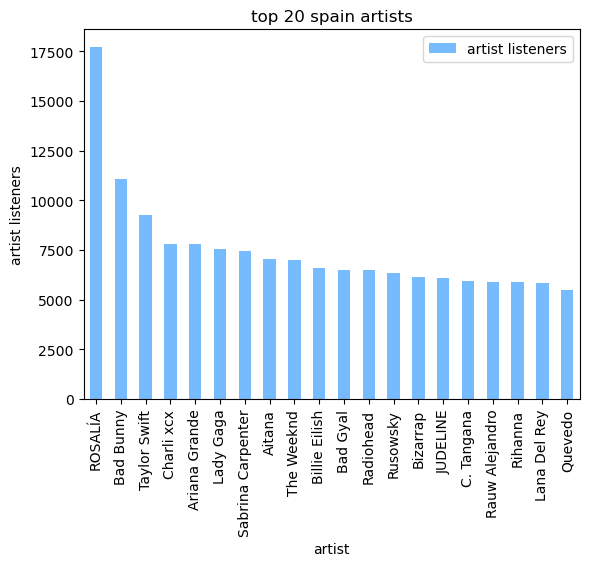

<Figure size 600x400 with 0 Axes>

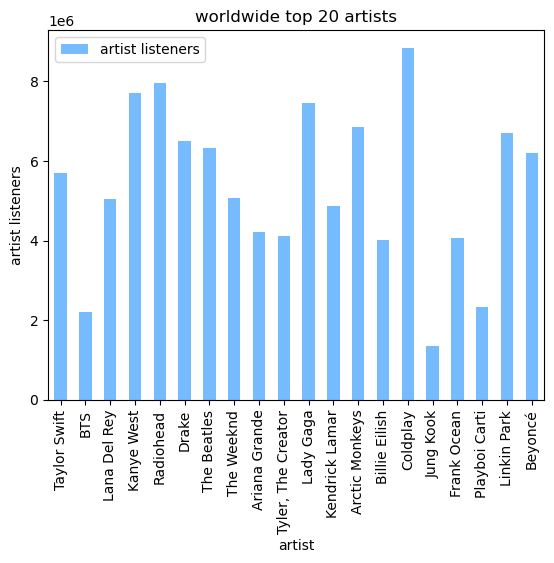

In [89]:
plt.figure(figsize=(6,4))
dfspainartists.head(20).plot(kind="bar", color="xkcd:sky blue", x= "artist", y="artist listeners")
plt.xticks(rotation=90)
plt.ylabel("artist listeners")
plt.title("top 20 spain artists")
plt.show()

plt.figure(figsize=(6,4))
df2.head(20).plot(kind="bar", color="xkcd:sky blue", x= "artist", y="artist listeners")
plt.xticks(rotation=90)
plt.ylabel("artist listeners")
plt.title("worldwide top 20 artists")
plt.show()
#graph de los top 20 artistas en espana y los top 20 del mundo